## Libraries

In [1]:
# Main libraries installation
!pip install gdown pykml basemap contextily > nul

In [2]:
# Data download and extraction
import gdown
import zipfile
import os

# KML parsing
import pykml
from pykml import parser
from lxml import etree

# Geospatial data manipulation and visualization
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

# Input/Output operations
from io import BytesIO

# Basemaps and context tiles
import contextily as cx

# Data retrieval and manipulation
import requests
import pandas as pd

# Interactive visualizations
import plotly.express as px

# Interactive maps
import folium
from folium.plugins import MarkerCluster

# Displaying Matplotlib plots inline
%matplotlib inline

import warnings  # Library for managing warnings
warnings.filterwarnings("ignore")  # Ignore warnings during runtime

import plotly.io as pio  # Library for handling Plotly I/O
from IPython.display import Image  # Library for displaying images in IPython environment

## Data Ingestion

In [3]:
# Read and parse KML file
with open("data/jp_kml/japan_boundaries.kml", "r") as f:
    kml = parser.parse(f)

In [4]:
# Print the parsed KML content
print(kml)

In [5]:
# KML file URL
url = 'https://kmlnetworklink.gsi.go.jp/kmlnetworklink/kml/gsi_ort.kml'

# Download the content of the KML file
response = requests.get(url)
kml_content = response.content

# Save the KML content to a local temporary file
local_filename = 'data/jp_kml/output/japan_boundaries.kml'
with open(local_filename, 'wb') as f:
    f.write(kml_content)

In [6]:
# Read the content of the KML file
with open("data/jp_kml/output/japan_boundaries.kml", "rb") as f:
    kml_content = f.read()

# Parse the content of the KML
root = etree.fromstring(kml_content)

# Find all Placemarks in the document
places = root.findall(".//{http://www.opengis.net/kml/2.2}Placemark")

# Now, 'places' should contain a list of Placemark elements
# You can iterate over them and perform the necessary operations
for place in places:
    # Perform the needed operations with each Placemark
    # For example, you can access coordinates with:
    coordinates = place.find(".//{http://www.opengis.net/kml/2.2}coordinates").text
    print("Coordinates:", coordinates)

## Data Exploring

In [7]:
# Set a limit for the number of elements to print
print_limit = 20
printed_count = 0

# Iterate over Placemarks and print information
for placemark in kml.getroot().Document.findall('.//{http://www.opengis.net/kml/2.2}Placemark'):
    # Check if the printed count has reached the limit
    if printed_count >= print_limit:
        break
    
    # Find the ExtendedData element
    extended_data_element = placemark.find('.//{http://www.opengis.net/kml/2.2}ExtendedData')

    if extended_data_element is not None:
        # Find the SchemaData element within ExtendedData
        schema_data_element = extended_data_element.find('.//{http://www.opengis.net/kml/2.2}SchemaData')

        if schema_data_element is not None:
            # Find SimpleData elements within SchemaData
            name_element = schema_data_element.find('.//{http://www.opengis.net/kml/2.2}SimpleData[@name="nam"]')
            district_element = schema_data_element.find('.//{http://www.opengis.net/kml/2.2}SimpleData[@name="laa"]')

            # Extract information or provide default values if not found
            name = name_element.text if name_element is not None and name_element.text is not None else "Nombre no encontrado"
            district = district_element.text if district_element is not None and district_element.text is not None else "Distrito no encontrado"
            
            # Extract coordinates
            coordinates = placemark.find('.//{http://www.opengis.net/kml/2.2}Polygon/{http://www.opengis.net/kml/2.2}outerBoundaryIs/{http://www.opengis.net/kml/2.2}LinearRing/{http://www.opengis.net/kml/2.2}coordinates').text.strip()

            # Uncomment the following lines if you want to print information
            # print("Prefecture:", name)
            # print("District/Province:", district)
            # print("Coordinates:", coordinates)
            # print("\n")
            
            # Increment the printed count
            printed_count += 1
        else:
            print("SchemaData not found in ExtendedData.")
    else:
        print("ExtendedData not found in Placemark.")

In [8]:
# Create a list to store Placemark geometries
geometries = []

# Iterate over Placemarks and create geometries
for placemark in kml.getroot().Document.findall('.//{http://www.opengis.net/kml/2.2}Placemark'):
    # Find the ExtendedData element
    extended_data_element = placemark.find('.//{http://www.opengis.net/kml/2.2}ExtendedData')

    if extended_data_element is not None:
        # Find the SchemaData element within ExtendedData
        schema_data_element = extended_data_element.find('.//{http://www.opengis.net/kml/2.2}SchemaData')

        if schema_data_element is not None:
            # Find SimpleData elements within SchemaData
            name_element = schema_data_element.find('.//{http://www.opengis.net/kml/2.2}SimpleData[@name="nam"]')
            district_element = schema_data_element.find('.//{http://www.opengis.net/kml/2.2}SimpleData[@name="laa"]')

            # Extract information or provide default values if not found
            name = name_element.text if name_element is not None and name_element.text is not None else "Nombre no encontrado"
            district = district_element.text if district_element is not None and district_element.text is not None else "Distrito no encontrado"
            
            # Extract coordinates
            coordinates = placemark.find('.//{http://www.opengis.net/kml/2.2}Polygon/{http://www.opengis.net/kml/2.2}outerBoundaryIs/{http://www.opengis.net/kml/2.2}LinearRing/{http://www.opengis.net/kml/2.2}coordinates').text.strip()

            # Parse coordinates and create a Shapely geometry
            coords = [tuple(map(float, coord.split(','))) for coord in coordinates.split()]
            if len(coords) > 2:
                # It's a polygon
                geometry = Polygon(coords)
            else:
                # It's a point
                geometry = Point(coords[0])

            geometries.append({'name': name, 'district': district, 'geometry': geometry})
        else:
            print("SchemaData not found in ExtendedData.")
    else:
        print("ExtendedData not found in Placemark.")

# Create a GeoDataFrame with GeoPandas
gdf = gpd.GeoDataFrame(geometries, geometry=gpd.GeoSeries([geom['geometry'] for geom in geometries]))

# Save as GeoJSON
gdf.to_file("data/jp_kml/output/output.geojson", driver="GeoJSON")

# Save as a Shapefile in a temporary file
temp_shapefile_path = "data/jp_kml/output/temp_shapefile.shp"
gdf.to_file(temp_shapefile_path, driver="ESRI Shapefile")

# Read the Shapefile
gdf_kml = gpd.read_file(temp_shapefile_path)

# Rename columns
gdf_kml = gdf_kml.rename(columns={'name': 'prefecture', 'district': 'city_district'})

# Display the GeoDataFrame
gdf_kml.head()

,prefecture,city_district,geometry
0,Hokkai Do,Sapporo Shi,"POLYGON ((141.44980 43.16333, 141.44769 43.157..."
1,Hokkai Do,Hakodate Shi,"POLYGON ((140.86501 42.01013, 140.86800 42.008..."
2,Hokkai Do,Otaru Shi,"POLYGON ((141.24820 43.15973, 141.24680 43.158..."
3,Hokkai Do,Asahikawa Shi,"POLYGON ((142.43280 43.94814, 142.43790 43.944..."
4,Hokkai Do,Muroran Shi,"POLYGON ((140.99080 42.43800, 140.99680 42.436..."


## Data Visualization

In [9]:
# Set the Coordinate Reference System (CRS) to EPSG:4326
gdf_kml = gdf_kml.set_crs(4326, allow_override=True)

In [ ]:
# Visualize the vector file of county subdivisions using Plotly Express and Mapbox
fig = px.choropleth_mapbox(gdf_kml,
                           geojson=gdf_kml.geometry.__geo_interface__,
                           locations=gdf_kml.index,
                           color='prefecture',  # Use 'name' for color
                           hover_data=['prefecture', 'city_district'],  # Add 'name' and 'district' to hover
                           mapbox_style="open-street-map",
                           center={"lat": gdf_kml.geometry.centroid.y.mean(), "lon": gdf_kml.geometry.centroid.x.mean()},
                           zoom=5,
                           color_continuous_scale='rainbow')

# Show the map
fig.show()

In [11]:
# Assuming 'fig' is your Plotly figure
pio.write_html(fig, 'data/jp_kml/output/map_japan_kml.html')

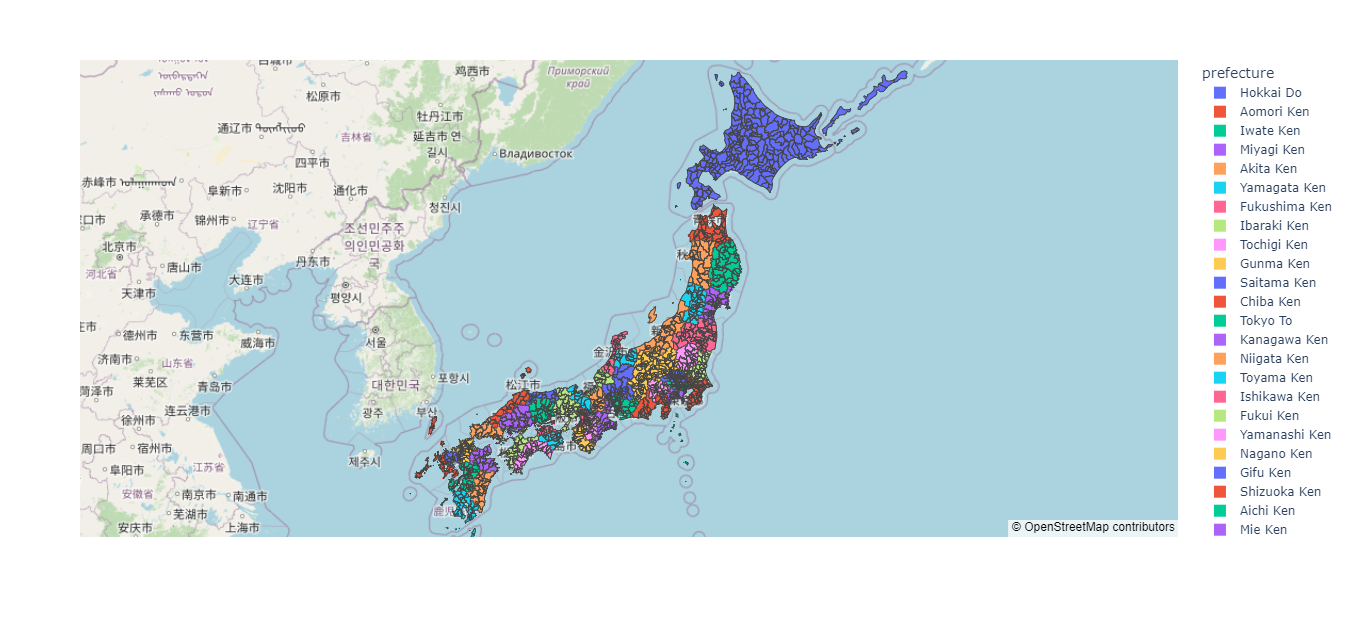

In [4]:
# Path to your PNG file
ruta_archivo_png = 'data/kml/japan_kml_view.png'  # Replace with the correct path

# Display the image in the notebook
Image(filename=ruta_archivo_png)